<a href="https://colab.research.google.com/github/MeeTK26/30DaysOfMLDL/blob/main/TransferLearningResNETforOccupationClassification(day21).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install albumentations

In [2]:
from icrawler.builtin import GoogleImageCrawler

def download_images(name, count, folder):
    crawler = GoogleImageCrawler(storage={"root_dir": folder})
    crawler.crawl(keyword=name, max_num=count)

download_images("Doctor", 300, "dataset/doctor")
download_images("Plumber", 300, "dataset/plumber")
download_images("Cricketer", 300, "dataset/cricketer")

ERROR:downloader:Response status code 404, file https://t4.ftcdn.net/jpg
ERROR:downloader:Response status code 400, file https://media.istockphoto.com/id/1473559425/zh/%E7%85%A7%E7%89%87/female-medical-practitioner-reassuring-a-patient.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/thumbnails/026/375/249/small_2x/ai-generative-portrait-of-confident-male-doctor-in-white-coat-and-stethoscope-standing-with-arms-crossed-and-looking-at-camera-photo.jpg
ERROR:downloader:Response status code 403, file https://www.wellingtonregional.com/sites/wellingtonregional.com/files/doctors_visit_1200x900.jpg
ERROR:downloader:Response status code 400, file https://media.istockphoto.com/id/1369619516/zh/%E7%85%A7%E7%89%87/shot-of-a-doctor-examining-a-patient-with-a-stethoscope-during-a-consultation-in-a-clinic.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/041/408/858/non_2x/ai-generated-a-smiling-d

In [18]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
import random


augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),

])


def augment_images(input_folder, output_folder, target_count=600):
    os.makedirs(output_folder, exist_ok=True)

    images = [img for img in os.listdir(input_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
    num_images = len(images)

    if num_images == 0:
        print(f"No images found in {input_folder}. Skipping...")
        return

    index = 1
    while num_images < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(input_folder, img_name)


        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        augmented = augmentations(image=image)['image']


        new_filename = f"aug_{index}_{img_name}"
        output_path = os.path.join(output_folder, new_filename)
        Image.fromarray(augmented).save(output_path)

        num_images += 1
        index += 1

    print(f"Augmented {input_folder} images to reach {target_count}.")


base_folder = "/content/dataset"
categories = ["cricketer", "doctor", "plumber"]


for category in categories:
    input_path = os.path.join(base_folder, category)
    augment_images(input_path, input_path, target_count=600)


Augmented /content/dataset/cricketer images to reach 600.
Augmented /content/dataset/doctor images to reach 600.
Augmented /content/dataset/plumber images to reach 600.


In [4]:
from tensorflow.keras.applications import ResNet50

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    "/content/dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training"
)

Found 1440 images belonging to 3 classes.


In [8]:
val_generator = train_datagen.flow_from_directory(
    "/content/dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation"
)

Found 360 images belonging to 3 classes.


In [9]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
from tensorflow.keras.layers import Dense, Flatten, Dropout

x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dense(4, activation="softmax")(x)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [12]:
model.fit(train_generator, validation_data=val_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 406s 9s/step - accuracy: 0.3486 - loss: 1.5842 - val_accuracy: 0.4361 - val_loss: 1.0577
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 397s 9s/step - accuracy: 0.4629 - loss: 1.0772 - val_accuracy: 0.5889 - val_loss: 1.0195
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 400s 9s/step - accuracy: 0.5117 - loss: 1.0005 - val_accuracy: 0.5528 - val_loss: 0.9711
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 409s 9s/step - accuracy: 0.5124 - loss: 1.0013 - val_accuracy: 0.5083 - val_loss: 0.9440
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 383s 9s/step - accuracy: 0.5458 - loss: 0.9701 - val_accuracy: 0.5500 - val_loss: 0.9619
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.5313 - loss: 0.9835 - val_accuracy: 0.5361 - val_loss: 0.9333
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 390s 9s/step - accuracy: 0.5634 - loss: 0.9319 - val_accuracy: 0.6417 - val_loss: 0.8433
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 389s 9s/step - accuracy: 0.5622 - loss: 0.9121 - val_accuracy: 0.6306 - v

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class_names = ["cricketer", "doctor", "plumber"]
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
def predict_face(image_path):
    img = preprocess_image(image_path)
    predictions = model.predict(img)[0]
    top_3_indices = np.argsort(predictions)[-3:][::-1]
    top_3_classes = [class_names[i] for i in top_3_indices]
    top_3_probs = [predictions[i] for i in top_3_indices]
    plt.imshow(cv2.imread(image_path)[..., ::-1])
    plt.axis('off')
    plt.title("Predictions:\n" + "\n".join([f"{top_3_classes[i]}: {top_3_probs[i]:.2%}" for i in range(3)]))
    plt.show()
    for i in range(3):
        print(f"{i+1}. {top_3_classes[i]}: {top_3_probs[i]:.2%}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


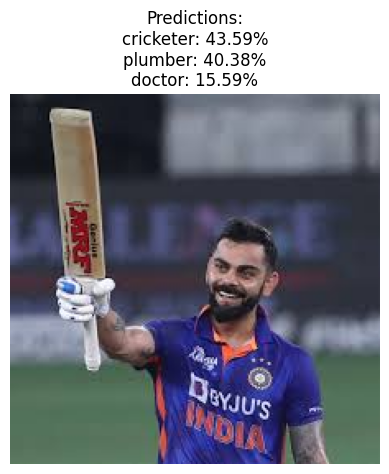

1. cricketer: 43.59%
2. plumber: 40.38%
3. doctor: 15.59%


In [15]:
image_path = "/content/criceketer.jpg"
predict_face(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


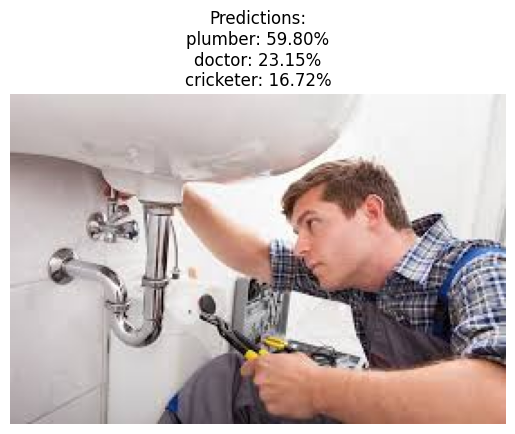

1. plumber: 59.80%
2. doctor: 23.15%
3. cricketer: 16.72%


In [16]:
image_path = "/content/plumber.jpg"
predict_face(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


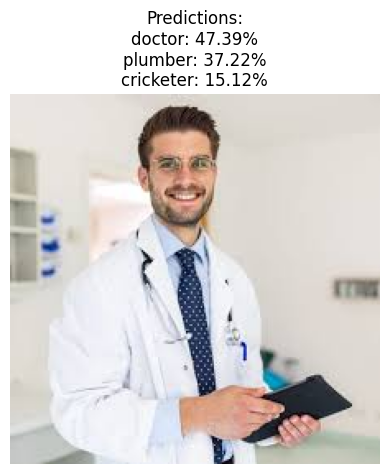

1. doctor: 47.39%
2. plumber: 37.22%
3. cricketer: 15.12%


In [17]:
image_path = "/content/doctor.jpg"
predict_face(image_path)